In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch  
import torch.nn as nn
import torch.nn.functional as F
from uszipcode import SearchEngine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Neural Net Class and Training Functions
Define Class and functions

In [104]:
def train_model(nn_model, X_train, y_train, X_eval, y_eval, k, max_iter=50, batch_size=32, print_n=10, verbose=True):
    '''
    Trains neural network model on X_train, y_train data.

    Parameters
    ----------
    X_train: np.array
        matrix of training data features
    y_train: np.array
        vector of training data labels
    k: int
        size of hidden layer to use in neural network
    max_iter: int
        maximum number of iterations to train for
    batch_size: int
        batch size to use when training w/ SGD
    print_n: int
        print training progress every print_n steps

    Returns
    ----------
    nn_model: torch.nn.Module
        trained neural network model
    '''
    # convert to tensors (for Pytorch)
    X_train_tensor = torch.tensor(X_train)
    y_train_tensor = torch.tensor(y_train)
    X_test_tensor = torch.tensor(X_eval)
    y_test_tensor = torch.tensor(y_eval)
    # intialize neural network
    n_samples, n_features = X_train_tensor.shape
    #nn_model = NN(n_features, k)
    nn_model.train()  # put model in train mode
    # initialize mse loss function
    mse_loss = torch.nn.MSELoss()
    # train with (mini-batch) SGD; initialize optimizer
    opt = torch.optim.SGD(nn_model.parameters(), lr=1e-4)
    losses_test = []
    for it in range(max_iter):
        # save losses across all batches
        losses = []
        # loop through data in batches
        for batch_start in range(0, n_samples, batch_size):
            # reset gradients to zero
            opt.zero_grad()
            # form batch
            X_batch = X_train_tensor[batch_start:batch_start+batch_size]
            y_batch = y_train_tensor[batch_start:batch_start+batch_size]
            X_batch_test = X_test_tensor[batch_start:batch_start+batch_size]
            y_batch_test = y_test_tensor[batch_start:batch_start+batch_size]
            # pass batch through neural net to get prediction
            y_pred = nn_model(X_batch.float())
            y_pred = y_pred.unsqueeze(1)
            y_pred_test = nn_model(X_batch_test.float())
            y_pred_test = y_pred_test.unsqueeze(1)
            #print(y_pred)
            # compute MSE loss
            loss = mse_loss(y_pred, y_batch[:, None].float())
            loss_test = mse_loss(y_pred_test, y_batch_test[:, None].float())
            # back-propagate loss
            loss.backward()
            # update model parameters based on backpropogated gradients
            opt.step()
            losses.append(loss.item())
            losses_test.append(loss.item())
        if verbose and it % print_n == 0:
            print(f"Mean Train MSE at step {it}: {np.mean(losses)}")
    return nn_model, losses_test

def evaluate_model(nn_model, X_eval, y_eval, batch_size=32):
    '''
    Evaluates trained neural network model on X_eval, y_eval data.

    Parameters
    ----------
    nn_model: torch.nn.Module
        trained neural network model
    X_eval: np.array
        matrix of training data features
    y_eval: np.array
        vector of training data labels
    batch_size: int
        batch size to looping over dataset to generate predictions

    Returns
    ----------
    mse: float
        MSE of trained model on X_eval, y_eval data
    '''
    # initialize mse loss function
    mse_loss = torch.nn.MSELoss()
    # convert to tensors (for Pytorch)
    X_eval_tensor = torch.tensor(X_eval)
    y_eval_tensor = torch.tensor(y_eval)
    n_samples = X_eval_tensor.shape[0]
    nn_model.eval() # put in eval mode
    # loop over data and generate predictions
    preds = []
    for batch_start in range(0, n_samples, batch_size):
        # form batch
        X_batch = X_eval_tensor[batch_start:batch_start+batch_size]
        y_batch = y_eval_tensor[batch_start:batch_start+batch_size]
        with torch.no_grad():  # no need to compute gradients during evaluation
            # pass batch through neural net to get prediction
            y_pred = nn_model(X_batch.float())
            y_pred = y_pred.unsqueeze(1)
            preds.append(y_pred)
    # compute MSE across all samples
    all_preds = torch.cat(preds)
    loss = mse_loss(all_preds, y_eval_tensor[:, None].float()).item()
    return loss

class NN(nn.Module):
    '''
    Class for fully connected neural net.
    '''
    def __init__(self, input_dim, hidden_dim):
        '''
        Parameters
        ----------
        input_dim: int
            input dimension (i.e., # of features in each example passed to the network)
        hidden_dim: int
            number of nodes in hidden layer
        '''
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layers = nn.Sequential(
            # Network should have a single hidden layer
            # Apply ReLU activation in between the hidden layer and output node
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class NN_configureable(nn.Module):
    '''
    Class for fully connected neural net.
    '''
    def __init__(self, input_dim, hidden_dim, hidden_layers):
        '''
        Parameters
        ----------
        input_dim: int
            input dimension (i.e., # of features in each example passed to the network)
        hidden_dim: int
            number of nodes in hidden layer
        '''
        super().__init__()
        #self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.layers = nn.ModuleDict()

        # Define input layer
        self.layers["input"] = nn.Linear(in_features = input_dim, out_features = hidden_dim)
        # Define hidden layers
        for i in range(self.hidden_layers):
            self.layers[f"hidden_{i}"] = nn.Linear(in_features = hidden_dim, out_features = hidden_dim)
        # Define output layer
        self.layers["output"] = nn.Linear(in_features = hidden_dim, out_features = 1)

    def forward(self, x):
        x = self.layers["input"](x)
        for i in range(self.hidden_layers):
            x = F.relu(self.layers[f"hidden_{i}"](x))

        return self.layers["output"](x)        
        

# Import Data
Get data from different sources before combining
* Cleaned up EV data: TX_WA_CO_NY.csv
* Average EV price and new car data over time: Avg_EV_Price.csv
* Census data (pop, household income, zipcode): census.csv 

In [112]:
def main():   
    # Import data
    X = pd.read_csv('./Data/df_X_county.csv')
    X['constant'] = 1
    y = pd.read_csv('./Data/df_y_county.csv')

    # check if any nan values
    nan_row_X = X[X.isna().any(axis=1)]
    #print(nan_row_X)
    nan_row_y = y[y.isna().any(axis=1)]
    #print(nan_row_y)

    X = X.to_numpy()
    y = y.to_numpy()

    # split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # standardize X
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    #print(X_test.shape)
    #print(y_test.shape)
    
    train_accuracies, test_accuracies = [], []

    # train NN model to predict EV registration using train data
    X_train_tensor = torch.tensor(X_train)
    n_samples, input_dim = X_train_tensor.shape
    n_layers = np.arange(1, 5) # iterate through hidden layer count
    n_hidden_dim = np.arange(8, 65, 8)  # iterate through hidden layer node count

    #nn_model_place = NN(input_dim, n_hidden_dim, n_layers)
    nn_model_place = NN(input_dim, 8)
    nn_model_result = train_model(nn_model_place, X_train, y_train, X_test, y_test, 16)
    train_mse = evaluate_model(nn_model_result[0], X_train, y_train)
    test_mse = evaluate_model(nn_model_result[0], X_test, y_test)

    print(f"Train MSE for model, dim = {8} is: {train_mse}")
    print(f"Test MSE for model, dim = {8} is: {test_mse}")

    # plot 3 models test errors
    plt.plot(range(len(nn_model_result[1])), nn_model_result[1])
    # axis labels
    plt.xlabel('Iteration Step')
    plt.ylabel('Test Error')
    plt.title("Model 1 - Hidden Layer - ReLU")
    plt.legend()
    plt.figure(figsize=(20,12))
    plt.show()


Mean Train MSE at step 0: 963764.8562825521
Mean Train MSE at step 10: 443291.7122533377
Mean Train MSE at step 20: 412039.615440691
Mean Train MSE at step 30: 392344.750091696
Mean Train MSE at step 40: 383235.77130556776
Train MSE for model, dim = 8 is: 300247.28125
Test MSE for model, dim = 8 is: 264452.0625


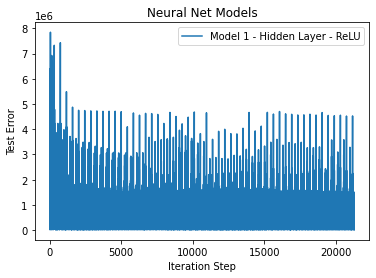

<Figure size 1440x864 with 0 Axes>

In [111]:
if __name__ == '__main__':
    main()